In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
import urllib.request, urllib.parse, urllib.error
import http
import sqlite3
import json
import time
import ssl
import sys

api_key = False
# If you have a Google Places API key, enter it here
# api_key = 'AIzaSy___IDByT70'

if api_key is False:
    api_key = 42
    serviceurl = "http://py4e-data.dr-chuck.net/json?"
else :
    serviceurl = "https://maps.googleapis.com/maps/api/geocode/json?"

# Additional detail for urllib
# http.client.HTTPConnection.debuglevel = 1

conn = sqlite3.connect('geodata.sqlite')
cur = conn.cursor()

cur.execute('''
CREATE TABLE IF NOT EXISTS Locations (address TEXT, geodata TEXT)''')

# Ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE
# where.data contains list of address for which you want to find latitude and longitude
fh = open("where.data")
count = 0
for line in fh:
    if count > 200 :
        print('Retrieved 200 locations, restart to retrieve more')
        break

    address = line.strip()
    print('')
    cur.execute("SELECT geodata FROM Locations WHERE address= ?",
        (memoryview(address.encode()), ))

    try:
        data = cur.fetchone()[0]
        print("Found in database ",address)
        continue
    except:
        pass

    parms = dict()
    parms["address"] = address
    if api_key is not False: parms['key'] = api_key
    url = serviceurl + urllib.parse.urlencode(parms)

    print('Retrieving', url)
    uh = urllib.request.urlopen(url, context=ctx)
    data = uh.read().decode()
    print('Retrieved', len(data), 'characters', data[:20].replace('\n', ' '))
    count = count + 1

    try:
        js = json.loads(data)
    except:
        print(data)  # We print in case unicode causes an error
        continue

    if 'status' not in js or (js['status'] != 'OK' and js['status'] != 'ZERO_RESULTS') :
        print('==== Failure To Retrieve ====')
        print(data)
        break
        
    #Memory view : memoryview objects allow Python code to access the internal data of an object that supports 
    #the buffer protocol without copying.The memoryview() function allows direct read and write access to an object’s
    #byte-oriented data without needing to copy it first. That can yield large performance gains when operating on
    #large objects since it doesn’t create a copy when slicing.
    
    cur.execute('''INSERT INTO Locations (address, geodata)
            VALUES ( ?, ? )''', (memoryview(address.encode()), memoryview(data.encode()) ) )
    conn.commit()
    if count % 10 == 0 :
        print('Pausing for a bit...')
        time.sleep(5)

print("Run geodump.py to read the data from the database so you can vizualize it on a map.")



Found in database  AGH University of Science and Technology

Found in database  Academy of Fine Arts Warsaw Poland

Found in database  American University in Cairo

Found in database  Arizona State University

Found in database  Athens Information Technology

Found in database  BITS Pilani

Found in database  Babcock University

Found in database  Banaras Hindu University

Found in database  Bangalore University

Found in database  Baylor University

Found in database  Beijing normal university

Found in database  Belarusian State University

Found in database  Belgrade University

Found in database  Beloit College

Found in database  Belorussian State University

Found in database  Ben Gurion University

Found in database  Bharthidasan University

Found in database  Boston University

Found in database  California Polytechnic State University of San Luis Obispo

Found in database  California State University San Bernardino

Found in database  City of Westminster College

Found in dat

Retrieved 1809 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=University+of+Erlangen-Nuremberg&key=42
Retrieved 2263 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=University+of+Essex&key=42
Retrieved 1572 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=University+of+Evora&key=42
Retrieved 1446 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=University+of+Florida&key=42
Retrieved 1820 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=University+of+Gothenburg&key=42
Retrieved 1814 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=University+of+Greifswald&key=42
Retrieved 1911 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=University+of+Hamburg&key=42
Retrieved 1797 characters {    "results" : [  

Retrieving http://py4e

Retrieved 2346 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=Warsaw+University&key=42
Retrieved 4589 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=Washington+State+University&key=42
Retrieved 1767 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=Wayne+State&key=42
Retrieved 1921 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=Weber+State&key=42
Retrieved 2112 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=Weizmann+Institute+of+Science&key=42
Retrieved 1919 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=Western+Governors+University&key=42
Retrieved 4895 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/json?address=Xavier+University&key=42
Retrieved 2301 characters {    "results" : [  

Retrieving http://py4e-data.dr-chuck.net/j

In [3]:
import sqlite3
import json
import codecs

conn = sqlite3.connect('geodata.sqlite')
cur = conn.cursor()

cur.execute('SELECT * FROM Locations')
fhand = codecs.open('where.js', 'w', "utf-8")
fhand.write("myData = [\n")
count = 0
for row in cur :
    data = str(row[1].decode())
    try: js = json.loads(str(data))
    except: continue

    if not('status' in js and js['status'] == 'OK') : continue

    lat = js["results"][0]["geometry"]["location"]["lat"]
    lng = js["results"][0]["geometry"]["location"]["lng"]
    if lat == 0 or lng == 0 : continue
    where = js['results'][0]['formatted_address']
    where = where.replace("'", "")
    try :
        print(where, lat, lng)

        count = count + 1
        if count > 1 : fhand.write(",\n")
        output = "["+str(lat)+","+str(lng)+", '"+where+"']"
        fhand.write(output)
    except:
        continue

fhand.write("\n];\n")
cur.close()
fhand.close()
print(count, "records written to where.js")
print("Open where.html to view the data in a browser")



aleja Adama Mickiewicza 30, 30-059 Kraków, Poland 50.06688579999999 19.9136192
Krakowskie Przedmieście 5, 00-068 Warszawa, Poland 52.2394019 21.0150792
AUC Avenue، 11835, Egypt 30.018923 31.499674
Tempe, AZ 85281, USA 33.4242399 -111.9280527
300, 2500 Daniells Bridge Rd, Athens, GA 30606, USA 33.9094132 -83.4603953
VidyaVihar Campus, street number 41, Pilani, Rajasthan 333031, India 28.3639976 75.58696809999999
Ilishan-Remo, Nigeria 6.8946472 3.7174267
Ajagara, Varanasi, Uttar Pradesh 221005, India 25.2677203 82.99125819999999
Gnana Bharathi Campus, Gnana Bharathi Main Rd, Teachers Colony, Nagarbhavi, Bengaluru, Karnataka 560056, India 12.9527314 77.5157387
1301 S University Parks Dr, Waco, TX 76706, USA 31.5497007 -97.1143046
19 Xinjiekou Outer St, BeiTaiPingZhuang, Haidian Qu, Beijing Shi, China, 100875 39.9619537 116.3662615
Praspyekt Nyezalyezhnastsi 4, Minsk, Belarus 53.8938988 27.5460609
Studentski trg 1, Beograd, Serbia 44.8184339 20.4575676
700 College St, Beloit, WI 53511, USA

307 records written to where.js
Open where.html to view the data in a browser


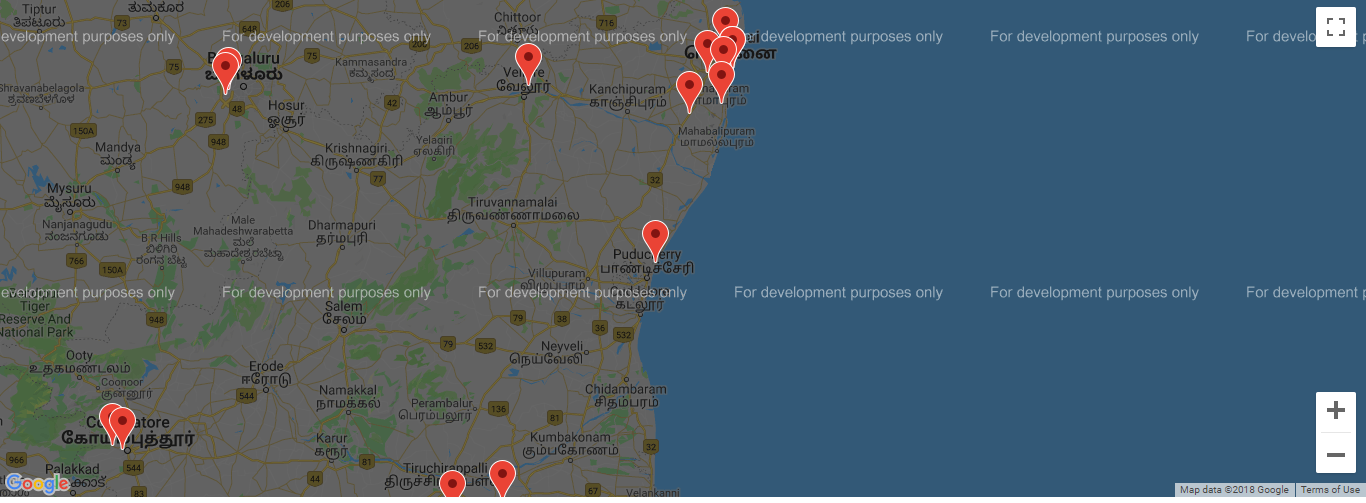

In [8]:
#WikiTableDataParser class fetch the data present in a table from given URL.
#We need to give the url along with class name of the table in the web page.
#We can save the data from wepage to csv file in the local directory and google drive
#We can also use tkinter to save the data in local directory

import requests
import pandas as pd
from bs4 import BeautifulSoup
from contextlib import closing


class WikiTableDataParser:
  
    def get_webpage(self,url):
      
      #Attempts to get the content at url by making an HTTP GET request with time out .
      #If the content-type of response is some kind of HTML, return the
      #HTML content, otherwise return None.
      try:
          with closing(requests.get(url, timeout=5)) as resp:
              if self.is_good_response(resp):
                  return resp.content
              else:
                  return None

      except RequestException as e:
          self.log_error('Error during requests to {0} : {1}'.format(url, str(e)))
          return None


    def is_good_response(self,resp):
      
       # Returns True if the response seems to be HTML, False otherwise.
        content_type = resp.headers['Content-Type'].lower()
        return (resp.status_code == 200 
                and content_type is not None 
                and content_type.find('html') > -1)


    def log_error(self,e):
      
        #It is always a good idea to log errors. 
        #This function just prints them, but you can
        #make it do anything.
        print(e)
        
    def parse_url(self, url, tableClass):
        response = self.get_webpage(url)
        # raises error for invalid URL
        if response is None:
            raise Exception("Invalid URL")
        soup = BeautifulSoup(response, 'html.parser')
        tables = soup.find_all('table')
       # print(tables)
        # raises error if data tables with given class are not found 
        if len(tables) <= 0:
           raise Exception("No tables found with clas : "+tableClass)
        return [(index,self.parse_html_table(table))\
                for index,table in enumerate(tables)]   

    def parse_html_table(self, table):
        n_columns = 0
        n_rows=0
        column_names = []

        # Find number of rows and columns in the table
        # we also find the column titles if we can
        for row in table.find_all('tr'):

            # Determine the number of rows in the table
            td_tags = row.find_all('td')
            if len(td_tags) > 0:
                n_rows+=1
                if n_columns == 0:
                    # Set the number of columns for our table
                    n_columns = len(td_tags)

            # Handle column names if we find them
            th_tags = row.find_all('th') 
            if len(th_tags) > 0 and len(column_names) == 0:
                for th in th_tags:
                    column_names.append(th.get_text())

        # raises error if column Titles and no.of.colmuns doesnt match
        if len(column_names) > 0 and len(column_names) != n_columns:
            raise Exception("Column titles do not match the number of columns")

        columns = column_names if len(column_names) > 0 else range(0,n_columns)
        df = pd.DataFrame(columns = columns,
                          index= range(0,n_rows))
        row_marker = 0
        for row in table.find_all('tr'):
            column_marker = 0
            columns = row.find_all('td')
            for column in columns:
                df.iat[row_marker,column_marker] = column.get_text()
                column_marker += 1
            if len(columns) > 0:
                row_marker += 1

        # Convert to float if possible
        for col in df:
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                pass

        return df
    
    # method to save the data in the local directory
    def save_as_csv_local(self, df, filename):
      try:
        df.to_csv(filename+".csv", index=False, header=True)
        return "Created in the working directory with filename : "+filename+".csv"
      except Exception as e:
        return e
      
     # method to save the data in file using UI
    def export_tkinter(self, df):
      try:
        import tkinter as tk
        from tkinter import filedialog
        from tkinter import Button
        from pandas import DataFrame
        root= tk.Tk()
        canvas1 = tk.Canvas(root, width = 300, height = 300, bg = 'lightsteelblue2', relief = 'raised')
        canvas1.pack()
        def exportCSV ():
            export_file_path = filedialog.asksaveasfilename()
            df.to_csv (export_file_path, index = None, header=True)
        saveAsButton_CSV = tk.Button(text='Export', command=exportCSV, bg='green', fg='white', font=('helvetica', 12, 'bold'))
        canvas1.create_window(150, 150, window=saveAsButton_CSV)
        tk.Button(root, text="Quit", command=root.destroy).pack()
        root.mainloop()
        return "file created"
      except Exception as e:
        return e   
    

In [9]:
url = "https://highereducationplus.com/top-100-universities-in-india-2018-by-nirf/"
hp = WikiTableDataParser()
#table_list = hp.parse_url(url, "table")
table_list = hp.parse_url(url,"dataTable")

print("total no of tables in the page",len(table_list))
#table_list[0][1]
for index,table in enumerate(table_list):
  print("index : ", index)
  table[1].head()

total no of tables in the page 1
index :  0


,0,1,2,3,4
0,Name,City,State,Score,Rank
1,Indian Institute of Science,Bengaluru,Karnataka,82.16,1
2,Jawaharlal Nehru University,New Delhi,Delhi,67.57,2
3,Banaras Hindu University,Varanasi,Uttar Pradesh,63.52,3
4,Anna University,Chennai,Tamil Nadu,62.82,4


In [5]:
college_df= table_list[0][1].iloc[1:,0]# getting only the names

In [11]:
college_df.head()

1    Indian Institute of Science
2    Jawaharlal Nehru University
3       Banaras Hindu University
4                Anna University
5        University of Hyderabad
Name: 0, dtype: object

In [33]:
hp.save_as_csv_local(college_df,"collegelist")

'Created in the working directory with filename : collegelist.csv'

In [10]:
hp.export_tkinter(college_df)

'file created'